# Dynamic topic modelling with BERTopic
### Coded by Sandrin Raphael Hunkeler (18-253-815)

## 1. Install Dependencies

In [1]:
import pandas as pd
import tomotopy as tp
import nltk
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import jupyterlab
import ipywidgets
import plotly
import kaleido
!pip3 install kaleido==0.1.0post1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Data

In [2]:
DATA = pd.read_csv(
    #"../rawData/sampler_10ktexts_perdecade.headed.ALL2.tsv",
    "../rawData/sampler_50ktexts_perdecade.headed.ALL.tsv",
    sep='\t',
    index_col=1
)
DATA.tail()

C:\Users\Siga\AppData\Local\Temp\ipykernel_12952\4139990483.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  DATA = pd.read_csv(


,file,text
line,,
49996,200X.POS.rand,I_PP beg_VBP to_TO move_VB ._SENT
49997,200X.POS.rand,<p> Ms_NN Blears_NP :_: I_PP certainly_RB shal...
49998,200X.POS.rand,<lb/> We_PP want_VBP to_TO make_VB improvement...
49999,200X.POS.rand,<lb/> I_PP turn_VBP now_RB to_TO the_DT propos...
50000,200X.POS.rand,<lb/> I_PP seek_VBP to_TO persuade_VB the_DT C...


## 3. Preprocessing
### 3.1 defining KEYWORDS and ROYALS name for selecting documents
### 3.2 extend STOP_WORDS by highly frequent words found in general sentences

In [3]:
KEYWORDS = [
    "king",
    "queen",
    "royalty",
    "majesty",
    "crown",
    "prince",
    "princess",
    "regent",
    "monarch",
    "highness"
]

ROYALS = [
    "Queen Victoria",
    "Queen Alexandra",
    "Queen Mary",
    "Queen Elizabeth",
    "King George",
    "King William",
    "King Edward",
    "King Edward",
    "Prince Albert",
    "Prince Edward",
    "Prince George",
    "Princess Victoria",
    "Princess Louise",
    "Princess Alexandra",
    "Princess Mary",
    "Princess Margaret"
]

STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
STOP_WORDS.update({
    'hon',
    'mr',
    'gentleman',
    'gent',
    'gen',
    'right',
    'house',
    'opinion',
    'sir',
    'say',
    'friend',
    'member',
    'think',
    'go',
    'motion'
    'noble',
    'lord',
    'case',
    'year',
    'speak',
    'speech'
})

SPACY_LANGUAGE = "en_core_web_sm"
COUNTRY = "US"
LANG = "en"
data = DATA

### 3.3 remove functional words
### 3.4 lemmatize words by POS tags

In [4]:
def corpusRefactoring(data):
    data.drop(data[~data['file'].astype(str).str.endswith('POS.rand')].index, inplace=True)
    data['file'] = data['file'].map(lambda x: x.rstrip('X.POS.rand'))
    data['file'] = data['file'].astype(str) + '0'
    data['file'] = pd.to_datetime(data['file'], format='%Y')
    data['file'] = pd.DatetimeIndex(data['file'])
    data.rename(columns={"file":"timePeriod", "text":"content"}, inplace=True)
    data.dropna(inplace = True)
    data.reset_index(drop=True, inplace=True)
    return data

def create_corpus(data):
    raw_articles = data["content"].to_list()
    corpus = tp.utils.Corpus()
    for doc in raw_articles:
        if doc:
            corpus.add_doc(doc.split())
    return _,  corpus

wn = WordNetLemmatizer()
def lemmatize(word):
    if '_' not in word: return ""
    token, posStart = word.split('_')[0].lower(), word.split('_')[1].upper()
    if posStart.startswith('N'):
        return wn.lemmatize(token, wordnet.NOUN)
    elif posStart.startswith('V'):
        return wn.lemmatize(token, wordnet.VERB)
    elif posStart.startswith('R'):
        return wn.lemmatize(token, wordnet.ADV)
    elif posStart.startswith('J'):
        return wn.lemmatize(token, wordnet.ADJ)
    return ""

def isRoyalTopic(text):
    if len(text.split()) < 4: return False
    overlapRoyals = any(word in ROYALS for word in text.split())
    overlapKeyWords = any(word in KEYWORDS for word in text.split())
    return overlapRoyals or overlapKeyWords

def preprocess_text(text):
    tokens = simple_preprocess(text)
    clean = [lemmatize(word) for word in tokens if lemmatize(word)!=""]
    words = [word for word in clean if word.isalpha()]
    lemmas = [word for word in words if word not in STOP_WORDS]
    return " ".join(lemmas)

In [5]:
corpusRefactoring(data)
data.loc[:, 'content'] = data['content'].apply(preprocess_text).astype(str)
data['royal'] = data['content'].apply(isRoyalTopic)
data.drop(data[data.royal == False].index, inplace=True)
data.dropna(inplace = True)
data.reset_index(drop=True, inplace=True)
data.tail()

,timePeriod,content,royal
23039,2000-01-01,viscount craigavon ask majesty government impo...,True
23040,2000-01-01,utterly wrong change name ruc remove royal cro...,True
23041,2000-01-01,chris bryant rhondda much hate agree liberal d...,True
23042,2000-01-01,also confirm majesty government make clear pri...,True
23043,2000-01-01,king bridgwater minister recall debate invasio...,True


In [6]:
#data = data.groupby("timePeriod").sample(frac=0.1, random_state=42)
data.reset_index(drop=True, inplace=True)
processedData = data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23044 entries, 0 to 23043
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timePeriod  23044 non-null  datetime64[ns]
 1   content     23044 non-null  object        
 2   royal       23044 non-null  bool          
dtypes: bool(1), datetime64[ns](1), object(1)
memory usage: 382.7+ KB


### 3.5 oversee the document frequencies

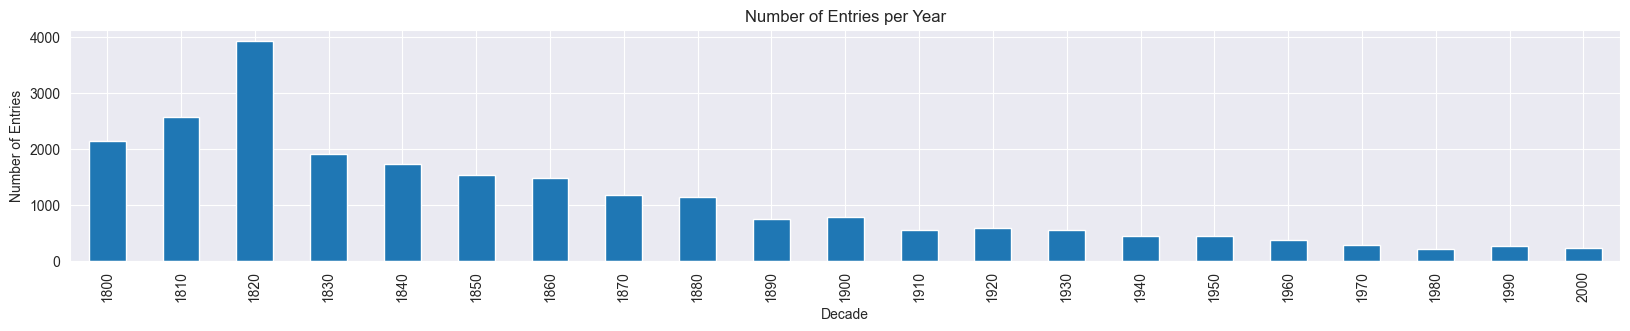

In [7]:
import matplotlib.pyplot as plt
data.groupby(data["timePeriod"].dt.year).size().plot(kind="bar", figsize=(20, 3))
plt.title("Number of Entries per Year")
plt.xlabel("Decade")
plt.ylabel("Number of Entries")
plt.savefig("../diagramOutput/frequencyDistributionRawDocuments.png", dpi=600, format='png', bbox_inches='tight')

## 4. BERTopic modelling
### 4.1 Definition of model parameters

In [8]:
model = BERTopic(
    umap_model=UMAP(n_neighbors=5, n_components=3, min_dist=0.0), #, low_memory=True), UMAP(n_neighbors=5, n_components=3, min_dist=0.0)
    hdbscan_model=HDBSCAN(min_cluster_size=50, min_samples=5, prediction_data = True),
    embedding_model=SentenceTransformer('all-MiniLM-L6-v2'),
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words='english'), #ngram_range=(1,2) -> ngram, 1 bis 2 wörter pro topic
    top_n_words=5,
    language='english',
    calculate_probabilities=False, #True
    verbose=True,
    nr_topics=15 #auto
)

### 4.2 process static topic modelling

In [ ]:
topics, _ = model.fit_transform(data['content'])

Batches:   0%|          | 0/721 [00:00<?, ?it/s]

### 4.3 process dynamic topic modelling

In [ ]:
topics_over_time = model.topics_over_time(
    data['content'],
    data['timePeriod'],
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=20
)

## 5. Analyze
### 5.1 Hierarchical Structure

In [ ]:
hierarchical_topics = model.hierarchical_topics(data['content'])
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

In [ ]:
fig = model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, title='<b>Hierarchical Clustering</b>')
fig.write_image("../diagramOutput/hierarchicalClustering.png", engine='kaleido', scale=3, format='png')
fig.show()

### 5.2 Visualize found Topics

In [ ]:
fig = model.visualize_barchart(top_n_topics=50, n_words=5, title='<b>Top Word Scores</b>')
fig.write_image("../diagramOutput/topicList.png", engine="kaleido", scale=3, format='png')
fig.show()

### 5.4 Visualize similarity between found topics

In [ ]:
model.visualize_heatmap()

### 5.5 Visualize topics over time

In [ ]:
#model.visualize_topics_over_time(topics_over_time, top_n_topics=5)
#model.visualize_topics_over_time(topics_over_time)

fig = model.visualize_topics_over_time(topics_over_time, title='<b>Topics over Time</b>')
fig.write_image("../diagramOutput/topicsOverTime.png", engine="kaleido", scale=3, format='png')
fig.show()

In [ ]:
for topic_id, topic_words in zip(topics_over_time['Topic'].unique(), topics_over_time['Words'].unique()):
    topic_mask = [i == topic_id for i in topics_over_time['Topic']]
    topic_df = topics_over_time[topic_mask]
    fig = model.visualize_topics_over_time(topic_df, title=f'<b>Topic {topic_id}</b><br>{topic_words}</br>')

    fig.write_image(f"../diagramOutput/topic{topic_id}_over_time.png", engine="kaleido", scale=3, format='png')
    fig.show()

In [ ]:
for topic_id, topic_words in zip(topics_over_time['Topic'].unique(), topics_over_time['Words'].unique()):
    topic_mask = [i == topic_id for i in topics_over_time['Topic']]
    topic_df = topics_over_time[topic_mask]
    fig = model.visualize_topics_over_time(topic_df,
                                           title=f'<b>Topic {topic_id}</b><br>{topic_words}</br>')

    fig.write_image(f"../diagramOutput/topic{topic_id}_over_time.png", engine="kaleido", scale=3, format='png')
    fig.show()


In [ ]:
topics_over_time.tail()

In [ ]:
fig = model.visualize_topics(title='<b>Intertopic Distance Map</b>')
fig.write_image("../diagramOutput/intertopicDistanceMap.png", engine="kaleido", scale=3, format='png')
fig.show()

### 5.5 Visualize dimension reduced cluster

In [ ]:
import pandas as pd
from umap import UMAP
%matplotlib inline

embeddings_vis = model._extract_embeddings(data['content'], method="document")
umap_model_vis = UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine').fit(embeddings_vis)
df_vis = pd.DataFrame(umap_model_vis.embedding_, columns=["x", "y"])
df_vis["topic"] = topics

In [ ]:
%matplotlib inline

# Plot parameters
top_n = 10000
fontsize = 5 #12

to_plot = df_vis.copy()
to_plot[df_vis.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

n_topics = len(np.unique(topics))
cmap = plt.get_cmap('hsv_r', n_topics)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(scatter)

plt.savefig("../diagramOutput/cluster.png", dpi=900, bbox_inches='tight')
plt.show()

In [ ]:
model.visualize_hierarchical_documents(data['content'], hierarchical_topics, embeddings=embeddings_vis)